# Scalable Modeling for DMDU

Decision Making Under Deep Uncertainty (DMDU) often leverages the use of complex, high-runtime models. These models can include optimization, equilibrium, agent-based, dynamical, or some combination thereof. Furthermore, the full space of scenarios that we seek to explore to quantify this uncertinty and ensure robustness is often times large, reaching hundreds of thousands, millions, or more scenarios.

How do we actually do this in practice?


##  Let's work through an example

As an example, we'll use an imaginary river basin--the Rio Imaginario--that is planning for resource availability over a 30-year time horizon. The population is growing, and demand for crops produced in the basin are expected to grow, but it's unclear how much. Key uncertainties include climate, which affects precipitation, streamflow,snowfall, and temperature; and water demand for both residential and agricultural users.  

Note that this problem is a simplification intended to illustrate a feasible approach: in reality, the model shown here could be run easily on a local computer.




In [64]:
# pull the repository if on collab
# !git clone https://github.com/jcsyme/rio_imaginario.git # HTTP (if on collab)
# !git clone git@github.com:jcsyme/rio_imaginario.git # SSH (otherwise)
# next, let's install some dependencies that we'll need
# !pip install ipywidgets
# !pip install pyDOE2


In [1]:
# import libraries
import warnings                    # we're going to turn off warnings for this notebook
warnings.filterwarnings("ignore")

import importlib                   # you can use this to reload modules if you `import MODULE as SHORTCUT`
import ipywidgets as wdgs          # we'll use this for some exploration of data
import itertools                   # lets us do outer product
import math                        # some math tools
import matplotlib.pyplot as plt    # plotting
import multiprocessing as mp       # parallelization
import numpy as np                 # may be the most ubiquitous python library--an array of numerical array tools
import os, os.path                 # directories and paths
import pandas as pd                # may be the second-most ubiquitous python library--data frames and manipulation
import scipy.optimize as sco       # optimization suite; good for small problems
import sys                         # we'll use this for some path setting
import time                        # a package for timing
from typing import *               # decorators for function specification


In [2]:
# next, let's import from the git we just cloned--let's add the python directory to the path so that python can find the models

# dir_py = os.path.join("/", "content", "rio_imaginario", "python") use if running on collab
# dir_py = PATHTOYOURPYHERE # use this if running locally outside of git
# if dir_py not in sys.path:
#     sys.path.append(dir_py)

import data_functions as dat
import ri_water_model as wm
import run_ri_model as rrm
import setup_analysis as sa
import support_functions as sf

# Let's Start by Instantiating a Model

The model is pre-packaged and ready for use in python. This, unfortunately, is rare. Real-world models are generally designed for the stakeholders' use cases, which are varied and often do not include robust exploratory modeling. There's generally some work involved in preparing or translating a model for exploratory modeling.

In [3]:
# instantiate the model
model = wm.RIWaterResourcesModel()


In [17]:
# in jupyter (*.ipynb) notebooks, use the "?" to view information about functions, classes, and other objects
?model

Signature:   model(*args, **kwargs) -> Any
Type:        RIWaterResourcesModel
String form: <ri_water_model.RIWaterResourcesModel object at 0x110790ad0>
File:        ~/Downloads/rio_imaginario/python/ri_water_model.py
Docstring:  
Create a water resources model for use in projecting different systemic 
    components. 
    
Optional Arguments
------------------
- dict_default_levers: dictionary of default lever parameter values. 
    Values specifie the value of the lever in 2050. Must include the 
    following keys:
    * "capacity_reservoir_million_m3": 300,
    * "increase_ag_efficiency_rate": 0,
    * "increase_mun_efficiency_rate": 0,
    * "transmission_gw_ag_m3s": np.nan,
    * "transmission_gw_mun_m3s": 2.5,
    * "transmission_res_ag_m3s": 10,
    * "transmission_res_mun_m3s": 10,
    * "recylcing_proportion_mun": 0.2,
    * "wastewater_treatment_capacity_m3s": 0.5
- dict_initial_states: dictionary of initial states for the Rio Imaginario
    reservoir and groundwater storage.

# Let's Get Data

Data (variables) and parameters are key to running a model. Garbage in, garbage out as the saying goes. If the data are good, a good model might be able to help information our decisions. If not, we may be better off using something else.

- Model: A mathematical system of equations used to describe relationships between inputs and outputs
- Variables: Any inputs to and outputs from the model
- Parameters: Uncertain variables related to the structure of the model that can be adjusted to modify the structure



In [4]:
# read in input data using the run_ri_model.py module (can be called to run an ensemble)
df_attr_strategy, df_climate_deltas_annual, df_model_data, df_strategies = rrm.load_data()

# set some generic variables we'll use
n = len(df_model_data)
fields_index = [
    sa.field_key_future,
    sa.field_key_strategy,
    sa.field_key_primary,
    sa.field_year,
    sa.field_month,
    sa.field_time_period
]



# Let's Look Through our Input Data

Inputs to the model include parameters--which, for this exercise, are stored in dictionaries in the `setup_analysis` module--and variables, which are stored in the `df_model_data` python variable.

In [5]:
def get_idp_xy(
    df: pd.DataFrame,
    field: str,
) -> np.ndarray:
    """
    Retrieve the x value for interactive plotting (time in years) and y value
    """
    x = df[sa.field_year].to_numpy() + (df[sa.field_month].to_numpy() - 0.5)/12
    y = df[field].to_numpy()
    
    out = (x, y)
    
    return out



def interactive_df_plot(
    df: pd.DataFrame,
    fields_ignore: List[str],
) -> wdgs.interactive:
    """
    Build an interactive ipywidget time seris plot for df. Will ignore fields specified
        in `fields_ignore`. 
    """
    
    # let's set fields to look at in the outputs
    flds_explore = sorted([x for x in df.columns if (x not in fields_ignore)])

    # build a quick widget
    dropdown = wdgs.Dropdown(
        options = flds_explore,
        value = flds_explore[0],
        description = "Select field to visualize",
    )
    
    # placeholder for other actions
    df_plot = df

    # function to allow interaction
    def plot_fields(
        field: str,
    ) -> 'plt.plot()':
        """
        Plot output fields from the model run on the df_model_data data frame
        """

        # set the time
        x, y = get_idp_xy(df_plot, field, )

        fig, ax = plt.subplots(figsize = (10, 5))
        ax.set_xlabel("Date")
        ax.set_ylabel(field)
        ax.plot(x, y)

        plt.show()

        return None

    out = wdgs.interactive(
        plot_fields,
        field = dropdown,
    )
    
    return out

In [6]:
interactive_df_plot(
    df_model_data,
    fields_index,
)


interactive(children=(Dropdown(description='Select field to visualize', options=('area_ag_km2', 'demand_agricu…

# Beyond Data, We Have Parameters

##  Initial States are Critical to a Simulation Model's Performance

Many policy models are sensitive to initial states. This includes dynamical models, simulation models, equilibrium models, agent-based models, and more. Initial states are boundary conditions used to start the model; in general, if using observational data, these should reflect empirical

In [7]:
wm.md_dict_initial_states


{'reservoir_storage_million_m3': 150, 'groundwater_storage_million_m3': 14000}

In [8]:

wm.md_dict_parameters


{'area_catchment_km2': 4000,
 'costs_unmet_demand': [5, 1000, 1000],
 'groundwater_inflow_m3s': 5,
 'maximum_gw_discharge_m3s': 12.5,
 'maximum_reservoir_outflow_m3s': 25,
 'proportion_gw_discharge': 0.015,
 'proportion_precip_runoff': 0.3,
 'proportion_precip_infiltration': 0.7,
 'proportion_agricultural_water_runoff': 0.5}

In [9]:

wm.md_dict_default_levers

{'capacity_reservoir_million_m3': 300,
 'increase_ag_efficiency_rate': 0,
 'increase_mun_efficiency_rate': 0,
 'transmission_gw_ag_m3s': nan,
 'transmission_gw_mun_m3s': 2.5,
 'transmission_res_ag_m3s': 10,
 'transmission_res_mun_m3s': 10,
 'recylcing_proportion_mun': 0.2,
 'wastewater_treatment_capacity_m3s': 0.5}

# We can run the model and look at outputs
- This part of the process is critical: we need to be able to trust the model
- **Validation** and **Calibration** are two key concepts that this plays into
    - Calibration: The process of adjusting parameters to make model outputs reflect an agreed upon benchmark, which often is based on empirical data
    - Validation: Process of determining whether or not the model is valid
        - Is it reasonable?
        - Does it behave as expected?
        - Does it reflect state of the art knowledge of the system?
        - Is there a good theoretical basis for the model?

In [10]:
# run the model with defaults and time it
t0 = time.time()
df_out_base = model.project(df_model_data)
t1 = time.time()
t_elapse = np.round(t1 - t0, decimals = 2)
print(f"\nTime elapsed to model completion: {t_elapse} seconds\n")

# show the 
df_out_base.tail()


Time elapsed to model completion: 1.06 seconds



,year,month,x_11_m3,x_12_m3,x_21_m3,x_22_m3,d_1_m3,d_2_m3,d_3_m3,s_1_m3,...,r_m3,f_1_m3,f_2_m3,groundwater_storage_m3,reservoir_storage_m3,reservoir_release_m3,reservoir_spillage_m3,gw_discharge_m3,gw_recharge_m3,precip_runoff_m3
499,2055,8,1.487083e+07,6696000.0,0.000000e+00,2.509246e+07,6.428389e+07,4.758413e+07,100000000.0,1.487083e+07,...,6696000.0,281250.0,1339200.0,0.0,0.000000e+00,6696000.0,0.0,0.0,8.174833e+06,8662500.0
500,2055,9,2.812983e+07,6480000.0,0.000000e+00,1.718324e+07,6.172126e+07,4.646567e+07,100000000.0,2.812983e+07,...,6480000.0,0.0,1296000.0,0.0,0.000000e+00,6480000.0,0.0,0.0,2.164983e+07,0.0
501,2055,10,2.017100e+07,6696000.0,3.967080e+06,2.678400e+07,6.157126e+07,4.422746e+07,100000000.0,2.413808e+07,...,6696000.0,75000.0,1339200.0,0.0,0.000000e+00,6696000.0,0.0,0.0,1.347500e+07,2310000.0
502,2055,11,8.276667e+06,6480000.0,2.592000e+07,2.592000e+07,5.927370e+07,4.310886e+07,100000000.0,3.419667e+07,...,64800000.0,442500.0,1296000.0,0.0,4.055487e+06,64800000.0,0.0,0.0,1.796667e+06,13629000.0
503,2055,12,2.088967e+07,6696000.0,2.678400e+07,2.678400e+07,5.473363e+07,4.199020e+07,100000000.0,4.767367e+07,...,52117675.0,1931250.0,1339200.0,0.0,4.140604e+07,52117675.0,0.0,0.0,1.419367e+07,59482500.0


In [11]:
# plot the output for the model
interactive_df_plot(
    df_out_base,
    fields_index,
)


interactive(children=(Dropdown(description='Select field to visualize', options=('d_1_m3', 'd_2_m3', 'd_3_m3',…

# Great, we have a model that looks like it runs. Let's assume it's calibrated and has been validated

Of course, these are critical steps. But we don't have time to explore this in depth, however,


##  The model is reliable. How can we incorporate uncertainty?

This is a small version of a somewhat complex model. It includes a numnber of pieces that sometimes interact in unexpected ways. It incorporates time series data over a relatively long time horizon (30+ years), and these data are not trivial to incorporate uncertainty for, including precipitation and streamflow records. This workbook includes codes that will do this for us, but we can examine how that works.


##  One of the key uncertainties is climate change

Let's examine some of the climate data we have.


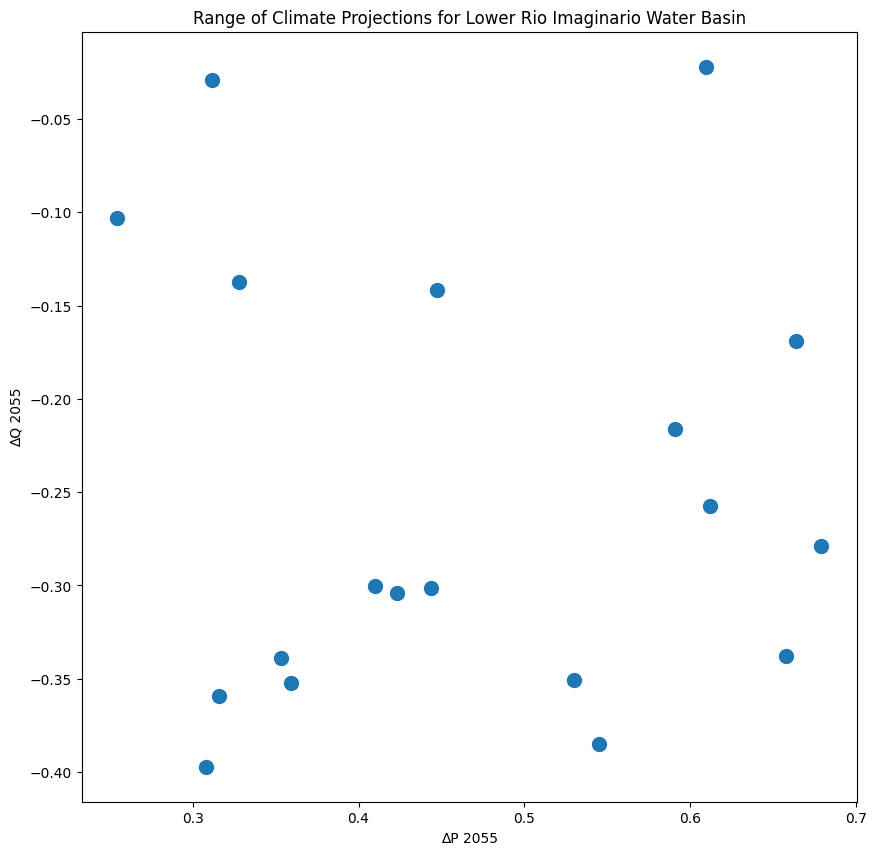

In [12]:
p = df_climate_deltas_annual["delta_p_2055_annual"]
q = df_climate_deltas_annual["delta_q_2055_annual"]

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlabel("∆P 2055")
ax.set_ylabel("∆Q 2055")
ax.set_title("Range of Climate Projections for Lower Rio Imaginario Water Basin")
plt.scatter(p, q, s = 100)

plt.show()


# How do we incorporate uncertainty into trajectories?

The uncertainty is incorporated depends on the model time period, metrics, and the decision context. This problem focuses on a long-term planning problem to ensure water availability--it's not so much about planning for intermittant droughts as it as ensuring the stability of service in the long run, while accounting for interrim variability. Our metrics will not focus on point in time estimates (e.g., 2050); they are focused on comparing longer-term averages. This guides how we think about climate affecting the uncertainties in place.

There are two key climate uncertainties affecting resource availability in the basin:

1. $\Delta P$: The average change in precipitation, measured from a 2011-2020 baseline to 2051-2060 in %
1. $\Delta Q$: The average change in streamflow in the river, measured from a 2011-2020 baseline to 2051-2060 in %

A routine has already been built to demonstrate how these can be adjusted.


##  **Note:** Other problems may call for other solutions

Synthetic streamflow/precipitation records are often pointed to as a potential part of the solution; those certainly can be, and it's defensible to use them in a problem like this to increase robustness against a range of potential outcomes. Additionally, climate deltas can sometimes include more refined information, such as changes by month; in these cases, synthetic records can be very useful for characterizing potential outcomes.    

For now, modifying historically-cyclied records is fine for our purposes. It captures historical variability while allowing us to characterize how longer-term changes might affect the system. This goes back to a key point--time and budget help dictate what you do.


In [13]:
# get the climate futures and other futures
df_futures, df_lhs, df_lhs_untransformed = rrm.build_futures(
    df_climate_deltas_annual,
    df_model_data
)

# For fun, we can confirm it's a successful LHC sample

A _Latin Hypercube_ is the multi-dimensional generalization of a Latin Square. the Latin Square is divided into $n$ x $n$ rows and columns, and $n$ points are filled in such that each row and each column have exactly one point. Sudoku is a familiar example of a Latin Square. The Latin Hypercube expands this idea to 3 (a cube) and 4+ (hypercubes) dimensions; sampling fills in the rows and columns on a $U(0, 1)$ distribution, so that each dimension has full support while stratifying the sample space. 

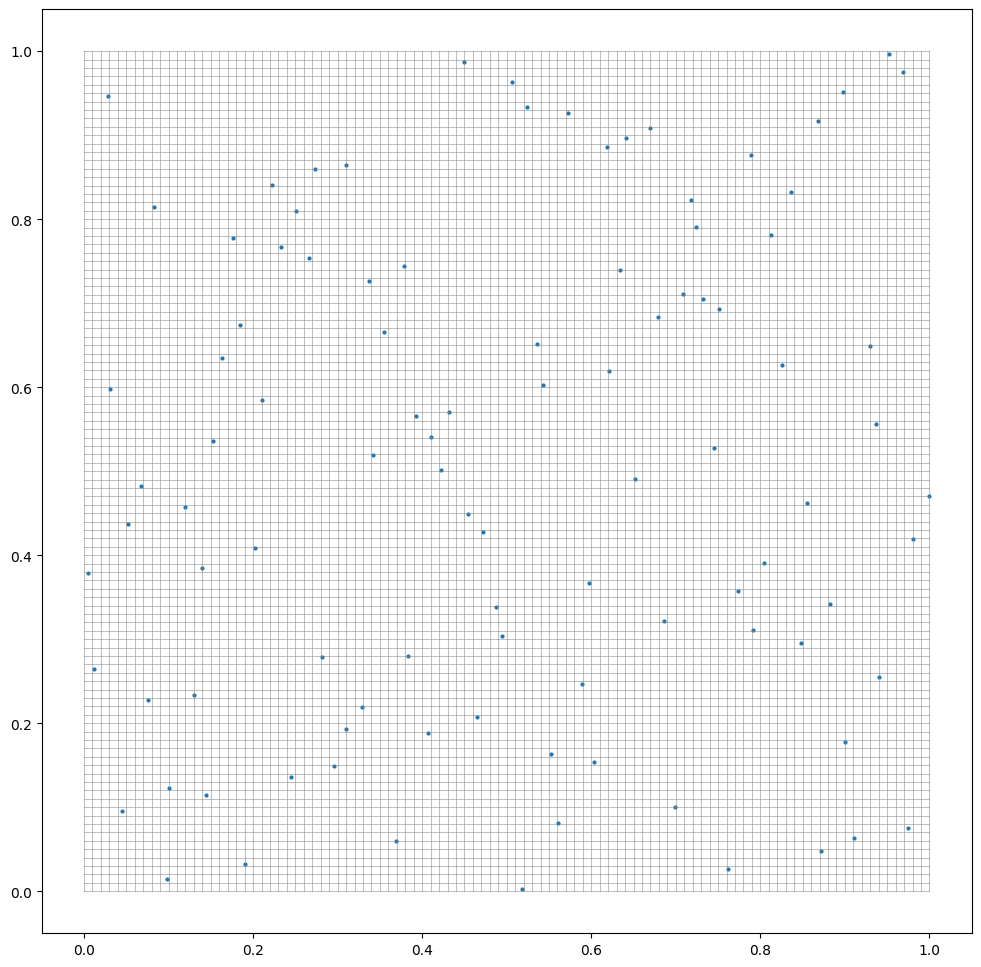

In [14]:
# pull arbitrary, raw LHS samples
x = df_lhs_untransformed["area_ag_km2"].to_numpy()
y = df_lhs_untransformed["demand_municipal_m3p"].to_numpy()

fig, ax = plt.subplots(figsize = (12, 12))

ax.scatter(x, y, s = 4)

n = len(x)
v = np.arange(2)

# add grid lines
for i in range(n + 1):
    
    # horizontal
    ax.plot(
        v, 
        np.array([i/n, i/n]), 
        color = "gray", 
        alpha = 0.5, 
        linewidth = 0.75,
    )
    
    # vertical
    ax.plot(
        np.array([i/n, i/n]), 
        v,
        color = "gray", 
        alpha = 0.5, 
        linewidth = 0.75,
    )

In [15]:
# define a function we can re-use
def interactive_df_plot_with_baseline(
    df: pd.DataFrame,
    fields_ignore: List[str],
) -> wdgs.interactive:
    """
    Build an interactive ipywidget time seris plot for df. Will ignore fields specified
        in `fields_ignore`. 
    """
    
    # let's set fields to look at in the outputs
    flds_explore = sorted([x for x in df.columns if (x not in fields_ignore)])

    # build a quick widget
    dropdown = wdgs.Dropdown(
        options = flds_explore,
        value = flds_explore[0],
        description = "Select field to visualize",
    )
    
    # slider for futures
    vec_futures = df[sa.field_key_future].unique()
    slider = wdgs.IntSlider(
        vec_futures.min(),
        vec_futures.min(),
        vec_futures.max(),
        1,
    )
    
    # placeholder for other actions
    df_plot_base = (
        df[
            df[sa.field_key_future].isin([0])
        ]
        .reset_index(drop = True)
    )
    
    # function to allow interaction
    def plot_fields(
        field: str,
        future: int,
    ) -> 'plt.plot()':
        """
        Plot output fields from the model run on the df_model_data data frame
        """
        
        df_plot_pert = (
            df[
                df[sa.field_key_future].isin([future])
            ]
            .reset_index(drop = True)
        )
        
        # get range for the field of interest -- fix the vertical axis
        window_exp = 0.1
        y0 = df[field].min()
        y0 = y0 - window_exp*np.abs(y0)
        
        y1 = df[field].max()
        y1 = y1 + window_exp*np.abs(y1)

        # get x/y for each
        x_base, y_base = get_idp_xy(df_plot_base, field, )
        x_pert, y_pert = get_idp_xy(df_plot_pert, field, )

        fig, ax = plt.subplots(figsize = (10, 5))
        ax.set_xlabel("Date")
        ax.set_ylabel(field)
        ax.set_ylim(y0, y1)
        
        ax.plot(x_base, y_base, color = "black", linewidth = 3)
        ax.plot(x_pert, y_pert, color = "dodgerblue", linewidth = 2)

        plt.show()

        return None

    out = wdgs.interactive(
        plot_fields,
        field = dropdown,
        future = slider,
    )
    
    return out

In [16]:
# explore what the uncertainties look like -- look at future 75
interactive_df_plot_with_baseline(
    df_futures,
    fields_index
)

interactive(children=(Dropdown(description='Select field to visualize', options=('area_ag_km2', 'demand_agricu…

In [17]:
interactive_df_plot_with_baseline(
    df_futures,
    fields_index
)

interactive(children=(Dropdown(description='Select field to visualize', options=('area_ag_km2', 'demand_agricu…

# Once futures are generated, we can run and identify vulnerabilities

If we have a set of strategies (collection of Ls) that we're evaluating, we could run those as well. This next step is context dependent. For example, in decarbonization, a vulnerability analysis of perturbed BAU scenarios (assuming we continue to emit as we are today, e.g.) is likely to be of low informational value without additional intervention. 

In [18]:

#
#   NOTE: this code is taken directly from run_ri_model.py;
# 

# built the attribute table and get primary ids to run--this is the primary scenario key, the index we use to facilitate paralleliation
df_attribute_primary = rrm.build_primary_attribute(df_lhs, df_attr_strategy, )
all_primaries = list(
    df_attribute_primary[
        df_attribute_primary[sa.field_key_strategy].isin(sa.strats_run)
    ][
        sa.field_key_primary
    ]
)

# lets only run those associated with our baseline strategy
all_primaries_run = list(
    df_attribute_primary[
        df_attribute_primary[sa.field_key_strategy].isin([0])
    ][
        sa.field_key_primary
    ]
)


##  RUN MODEL IN PARALLEL USING DATA


# initialize callback function - note vec_df_out_ri is specified OUTSIDE of main()
vec_df_out_ri = []
def _get_result(result):
    global vec_df_out_ri
    vec_df_out_ri.append(result)


# start the MP pool for asynchronous parallelization
t0_par_async = time.time()

print("Starting pool.async()...")


# start the pool
pool = mp.Pool(int(mp.cpu_count()))

for id_primary in all_primaries_run:

    # get data for this primary key
    df_input_data = rrm.get_model_data_from_primary_key(
        id_primary,
        df_attribute_primary,
        df_futures,
        df_strategies,
        sa.field_key_primary,
        sa.field_key_future,
        sa.field_key_strategy
    )
    
    # apply to pool
    pool.apply_async(
        model.project,
        args = (
            df_input_data,
        ),
        kwds = {
            "id_primary": id_primary,
        },
        callback = _get_result,
    )

pool.close()
pool.join()

t1_par_async = time.time()
t_delta = np.round(t1_par_async - t0_par_async, 2)
print(f"Pool.async() done in {t_delta} seconds.\n")



##  FINISH UP
    
# collect output
df_metrics_base, df_all_output_base = rrm.get_metric_df_out(
    vec_df_out_ri,
    save_complete = True,
)





Starting pool.async()...


/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18

Pool.async() done in 27.17 seconds.



array([[<AxesSubplot: title={'center': 'mean_reservoir_storage_last_ten_years_m3'}>,
        <AxesSubplot: title={'center': 'mean_groundwater_storage_last_ten_years_m3'}>],
       [<AxesSubplot: title={'center': 'proportion_unacceptable_unmet_demand'}>,
        <AxesSubplot: >]], dtype=object)

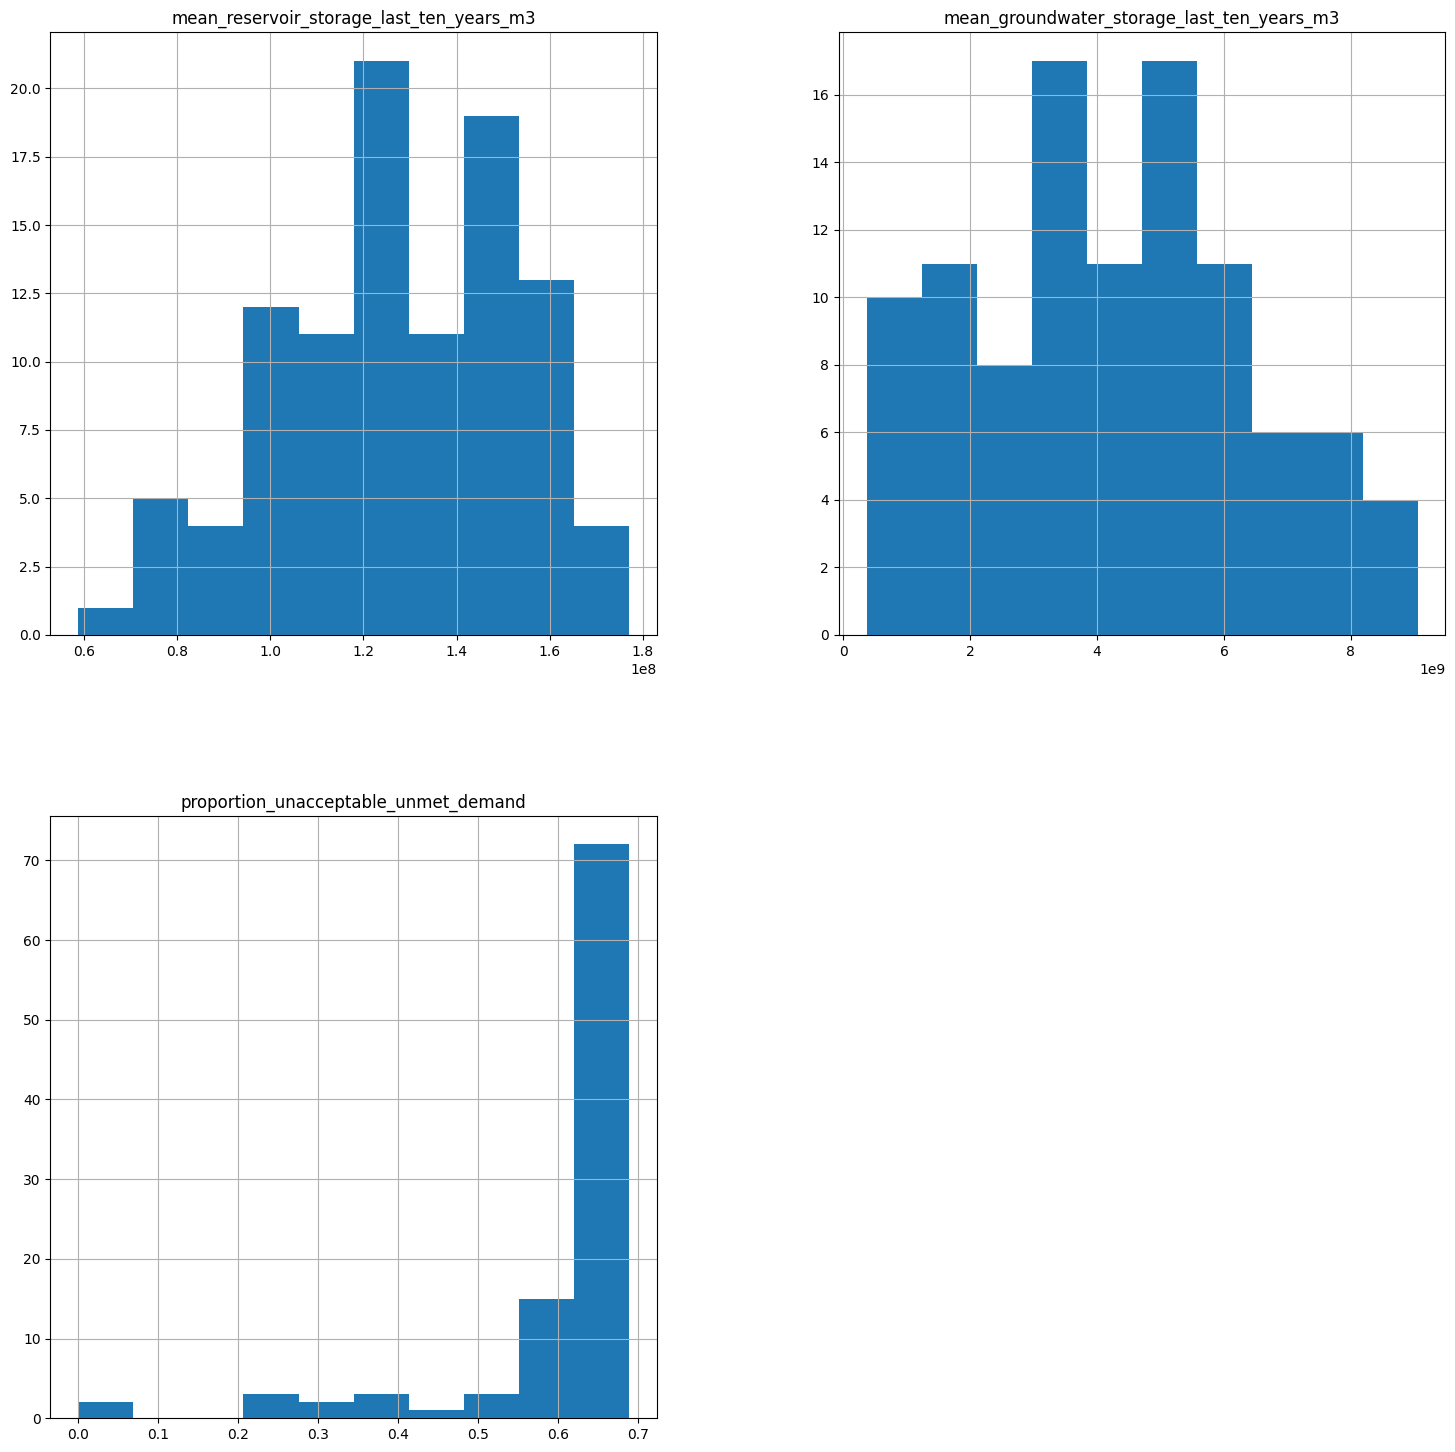

In [19]:
fig, ax = plt.subplots(figsize = (18, 18))
(
    df_metrics_base
    .drop(columns = [sa.field_key_primary])
    .hist(ax = ax)
)

In [ ]:
fig, ax = plt.subplots(figsize = (18, 18))
df_metrics_base.hist(ax = ax)

In [48]:
df_summary = pd.merge(
    df_attribute_primary,
    df_metrics_base,
    how = "inner"
)

df_summary = pd.merge(
    df_summary,
    df_lhs,
    how = "inner"
)



In [60]:
for k in sorted(df_summary.columns):
    if "_id" in k:
        continue
        
    print(k)

area_ag_km2
demand_agricultural_m3km2
demand_municipal_m3p
flow_m3s
mean_groundwater_storage_last_ten_years_m3
mean_reservoir_storage_last_ten_years_m3
population
precipitation_mm
proportion_unacceptable_unmet_demand


<AxesSubplot: xlabel='population', ylabel='proportion_unacceptable_unmet_demand'>

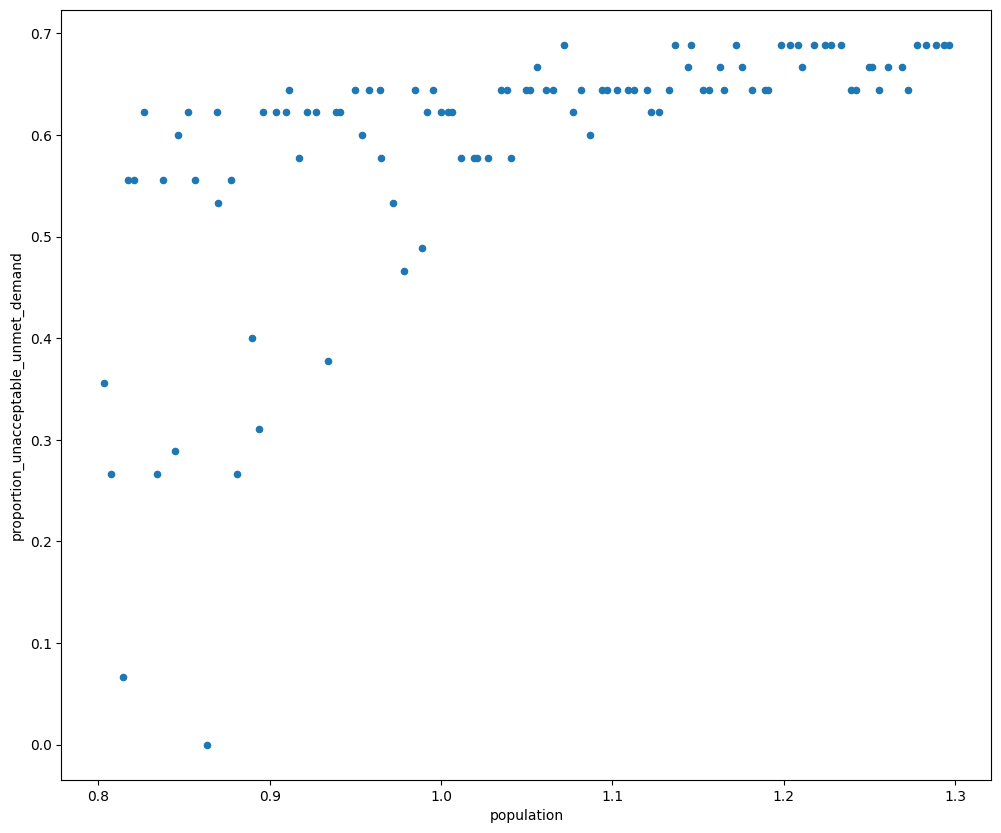

In [63]:
x = "population"
y = "proportion_unacceptable_unmet_demand"


fig, ax = plt.subplots(figsize = (12, 10))
(
    df_summary[[x, y]]
    .plot(x = x, y = y, kind = "scatter", ax = ax)
)

In [53]:
?df_summary.plot

Signature:      df_summary.plot(*args, **kwargs)
Type:           PlotAccessor
String form:    <pandas.plotting._core.PlotAccessor object at 0x19abcd550>
File:           ~/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/pandas/plotting/_core.py
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
